In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Загрузим все наборы данных данного проекта

In [2]:
train_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

Объединим таблицы ```*transaction``` и ```*identity``` по полю ```TransactionID```

In [3]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

Т.к. мы объединили датасеты ```*identity``` и ```*transaction```, удалим их для того, чтобы освободить память

In [4]:
del train_transaction
del train_identity
del test_transaction
del test_identity
gc.collect

<function gc.collect(generation=2)>

Создадим копии датасетов, с которыми будем работать, чтобы не менять исходники

In [5]:
train_df = train.copy()
test_df = test.copy()

Посмотрим какой объём оперативной памяти занимают датасеты:

In [6]:
train_df_GB = train_df.memory_usage(deep=True).sum()/1024**3
test_df_GB = test_df.memory_usage(deep=True).sum()/1024**3

print(f'train df: {train_df_GB:.2f} GB of memory')
print(f'test df : {test_df_GB:.2f} GB of memory')

train df: 2.51 GB of memory
test df : 2.16 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма будет затрачено большое кол-во ресурсов и довольно длительное время.

Напишем функцию подсчёта объема занимаемой памяти:

In [7]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return usage_mb

Напишем функцию для уменьшения объёма занимаемой памяти датасетом.

1. Преобразуем все значения подтипов ```int``` в тип ```uint```, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти.

2. Все значения подтипов ```float``` в тип ```float```
2. ```object``` в ```category```

In [8]:
def reduce_mem_usage_num(df, name):
    start_memory = memory_usage(df)
    
    # convert int
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    
    # convert float
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric, downcast='float')
    
    optimized_df = df.copy()
    optimized_df[converted_int.columns] = converted_int
    optimized_df[converted_float.columns] = converted_float
    
    finish_memory = memory_usage(optimized_df)
    diff_memory = start_memory - finish_memory
    diff_memory_prct = 100 - ((finish_memory * 100)/start_memory)
    print(f'start memory of {name} is {start_memory} Mb')
    print(f'memory after optimization of {name} is {finish_memory} Mb')
    print(f'memory usage of {name} decreased on {diff_memory} Mb ({diff_memory_prct} %)\n')
    return optimized_df

In [9]:
train_df = reduce_mem_usage_num(train_df, 'train_df')
test_df = reduce_mem_usage_num(test_df, 'test_df')

start memory of train_df is 2567.094612121582 Mb
memory after optimization of train_df is 1656.4279747009277 Mb
memory usage of train_df decreased on 910.6666374206543 Mb (35.47460358962117 %)

start memory of test_df is 2214.031036376953 Mb
memory after optimization of test_df is 1436.0497455596924 Mb
memory usage of test_df decreased on 777.9812908172607 Mb (35.13868044462248 %)



In [10]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].astype('category')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2), uint8(1)
memory usage: 924.3 MB


In [12]:
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].astype('category')

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2)
memory usage: 792.6 MB


In [14]:
print(f'train_df decreased on {100 - (memory_usage(train_df) * 100)/2567.094} %')
print(f'test_df decreased on {100 - (memory_usage(test_df) * 100)/2214.031} %')

train_df decreased on 63.989099234193674 %
test_df decreased on 64.19355467369698 %


Видим, что объём памяти, занимаемый каждым датасетом после преобразования типов признаков уменьшился примерно на ```64``` %

#### Напишем функцию, которая будет представлять отчёт о пропусках в данных

In [15]:
def missing_values_table(df, df_name):
    mis_val = df.isnull().sum()
    len_df = len(df)
    mis_val_percent = 100 * mis_val / len_df
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print(f'{df_name} has ', str(df.shape[1]) + ' columns.\n',
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          ' columns that have missing values.')
    return mis_val_table_ren_columns

In [16]:
missing_values_table(train_df, 'train_df')

train_df has  434 columns.
 There are 414 columns that have missing values.


,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
...,...,...
V285,12,0.0
V284,12,0.0
V280,12,0.0
V279,12,0.0


In [17]:
missing_values_table(test_df, 'test_df')

test_df has  433 columns.
 There are 385 columns that have missing values.


,Missing Values,% of Total Values
id-24,501951,99.1
id-25,501652,99.0
id-26,501644,99.0
id-08,501632,99.0
id-07,501632,99.0
...,...,...
V293,3,0.0
C14,3,0.0
V319,3,0.0
V292,3,0.0


Заменим признаки с ```-``` в тестовом датасете на соответствующие названия из тренировочного датасета с ```_```

In [18]:
test_df = test_df.rename(columns=lambda x:'_'.join(x.split('-')))

In [19]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,C,13832,375.0,185.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.173000,C,3154,408.0,185.0,mastercard,224.0,debit,...,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,4170237,34214326,49.000000,W,16661,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,4170238,34214337,202.000000,W,16621,516.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удаляем признаки, в которых более ```50 %``` пропусков:

In [20]:
missing_df = missing_values_table(train_df, 'train_df')
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50.0].index)
print('We will remove %d columns.' % len(missing_columns))

train_df has  434 columns.
 There are 414 columns that have missing values.
We will remove 214 columns.


In [21]:
train_df = train_df.drop(columns = missing_columns)

In [22]:
train_df.shape

(590540, 220)

In [23]:
test_df = test_df.drop(columns = missing_columns)
test_df.shape

(506691, 219)

Посмотрим ещё раз на пропуски 

In [24]:
miss_val_train_df = missing_values_table(train_df, 'train_df')
miss_val_train_df

train_df has  220 columns.
 There are 200 columns that have missing values.


,Missing Values,% of Total Values
M4,281444,47.7
D2,280797,47.5
V7,279287,47.3
V11,279287,47.3
V10,279287,47.3
...,...,...
V295,12,0.0
V297,12,0.0
V298,12,0.0
V299,12,0.0


In [25]:
missing_values_table(test_df, 'test_df')

test_df has  219 columns.
 There are 171 columns that have missing values.


,Missing Values,% of Total Values
M4,237745,46.9
D2,234769,46.3
D3,203142,40.1
M3,176639,34.9
M2,176639,34.9
...,...,...
V287,3,0.0
V290,3,0.0
V292,3,0.0
V293,3,0.0


И посмотрим насколько ещё уменьшился занимаемый объём памяти каждого из датасетов

In [26]:
print(f'train_df memory usage: {memory_usage(train_df)} Mb')
print(f'test_df memory usage: {memory_usage(test_df)} Mb')

train_df memory usage: 477.58735275268555 Mb
test_df memory usage: 409.29405784606934 Mb


### Разделим обучающую выборку на обучение и тест

Отделим данные от целевой переменной

In [27]:
X = train_df.drop(columns='isFraud')
y = train_df['isFraud']

In [28]:
y

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: uint8

Разделим обучающую выборку в процентном соотношении:
- train - ```70%```
- test - ```30%```

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3)

In [30]:
X_train.shape

(413378, 219)

In [31]:
y_train.shape

(413378,)

In [32]:
X_valid.shape

(177162, 219)

In [33]:
y_valid.shape

(177162,)

### Посмотрим на распределения признаков до заполнения пропусков

#### Посмотрим на распределение целевой переменной ```isFraud```

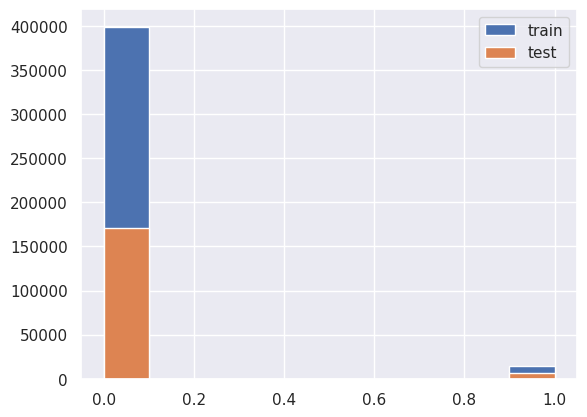

In [34]:
sns.set()
plt.hist(y_train, label='train')
plt.hist(y_valid, label='test')
plt.legend()

In [35]:
isFraud_count = y_train.value_counts()
isFraud_prct = y_train.value_counts()/len(y_train)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,398914,0.96501
1,14464,0.03499


In [36]:
isFraud_count = y_valid.value_counts()
isFraud_prct = y_valid.value_counts()/len(y_valid)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,170963,0.965009
1,6199,0.034991


Видим, что данные не сбалансированы:

- ```96,5 %``` транзакций - валидны

- ```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки.

Напишем функцию для построения распределений признаков

In [37]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[feature].value_counts().plot(kind='bar',
                                            figsize=(7,5),
                                            xlabel=title,
                                            ylabel='count',
                                            edgecolor='k',
                                            color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom'
        )
    
    plt.show()

#### Распределение ```Card 4``` (компания карты)

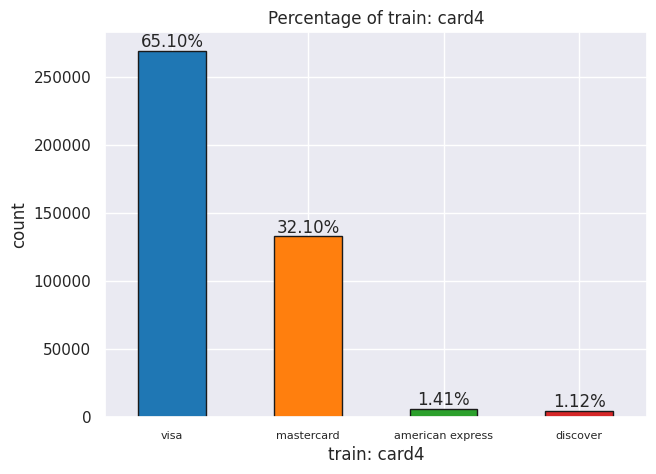

In [38]:
plot_value_counts('card4', 'train: card4', df=X_train)

Видим, что:

- ```65,34 %``` - карт компании 'visa'
- ```31,61 %``` - 'mastercard'
- ```1,68 %```  - 'american express'
- ```1,16 %```  - 'discover'

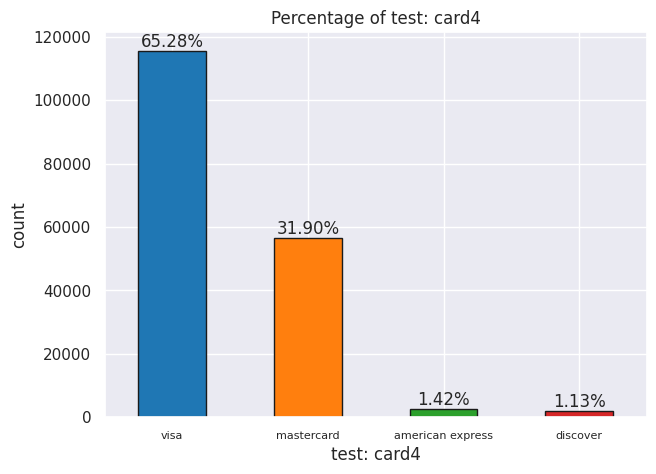

In [39]:
plot_value_counts('card4', 'test: card4', df=X_valid)

#### Распределение ```Card 6``` - тип карты

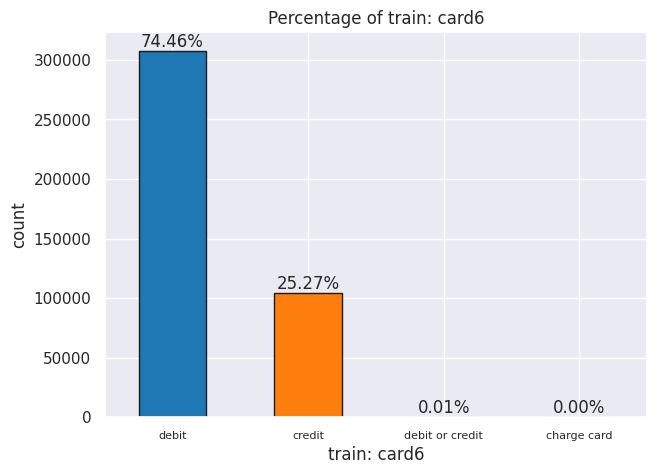

In [40]:
plot_value_counts('card6', 'train: card6', df=X_train)

Большая часть транзакций произведена дебетовыми картами - ```73,17 %```, ```26,61 %``` - кредитными картами. Транзакций с ```charge``` карт нет

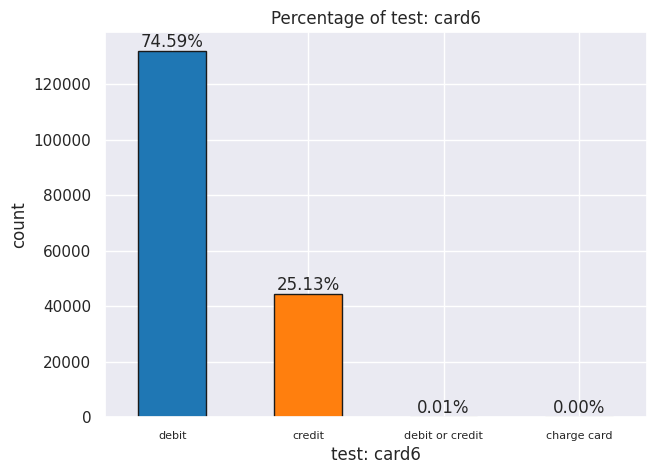

In [41]:
plot_value_counts('card6', 'test: card6', df=X_valid)

#### Посмотрим на распределение транзакций в разрезе компаний, выпустивших карты

Напишем функцию для визуализации распределения транзакций в разрезе какого-либо признака

In [42]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df)
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

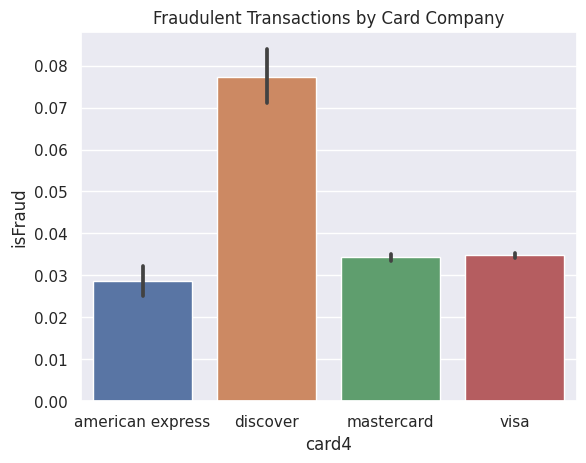

In [43]:
isFraud_by_feature('card4', df=train_df, title='Card Company')

Большинство операций произведено с карт ```discover```

#### Распределение транзакций в разрезе типа карты

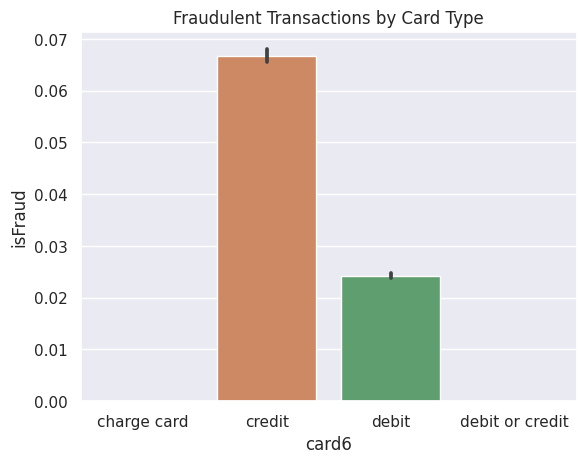

In [44]:
isFraud_by_feature('card6', df=train_df, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25,23 %``` от всего объема данных, с них произведена большая часть транзакций

### Посмотрим, есть ли в данных дубликаты

In [45]:
X_train.duplicated().sum()

0

In [46]:
X_valid.duplicated().sum()

0

### Преобразуем категориальные признаки в числа

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 581658 to 57073
Columns: 219 entries, TransactionID to V321
dtypes: category(9), float32(207), uint16(1), uint32(2)
memory usage: 337.1 MB


In [48]:
for f in X_train.columns:
    if X_train.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_train.loc[:, f].values))
        X_train.loc[:, f] = le.transform(list(X_train.loc[:, f].values))

In [49]:
X_train

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
581658,3568658,15533085,107.000000,4,14858,558.0,150.0,4,226.0,2,...,107.000000,0.000000,0.000000,0.000000,0.0,167.0,0.0,0.000000,0.000000,0.000000
454948,3441948,11639725,108.500000,4,17188,321.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
220622,3207622,5180573,226.000000,4,16659,170.0,150.0,4,226.0,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
409762,3396762,10354375,8.761000,0,5812,408.0,185.0,2,224.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
283716,3270716,6928923,30.950001,4,9112,250.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42084,3029084,1023194,100.000000,3,2408,571.0,150.0,4,226.0,2,...,200.000000,100.000000,100.000000,100.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
269441,3256441,6540941,208.949997,4,16659,170.0,150.0,4,226.0,1,...,425.670013,425.670013,425.670013,425.670013,0.0,0.0,0.0,208.949997,208.949997,208.949997
218753,3205753,5106604,226.000000,4,2616,NaN,150.0,1,102.0,1,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
422738,3409738,10701858,15.000000,4,5251,555.0,150.0,4,166.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [50]:
for f in X_valid.columns:
    if X_valid.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_valid.loc[:, f].values))
        X_valid.loc[:, f] = le.transform(list(X_valid.loc[:, f].values))

In [51]:
X_valid

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
258608,3245608,6204621,34.000000,4,15077,127.0,150.0,2,102.0,1,...,39.0,34.0,114.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
467328,3454328,12048998,171.000000,4,17321,111.0,150.0,4,226.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325467,3312467,8026823,77.000000,4,12695,490.0,150.0,4,226.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252068,3239068,6024807,87.000000,4,15813,251.0,150.0,4,226.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31948,3018948,782287,30.000000,4,13481,199.0,150.0,2,224.0,2,...,39.0,29.0,248.0,78.0,0.0,1243.5,266.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117366,3104366,2297780,150.000000,2,13883,127.0,150.0,2,224.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447736,3434736,11399969,44.143002,0,4329,238.0,185.0,4,102.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327053,3314053,8042393,34.500000,4,13982,218.0,150.0,2,117.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49357,3036357,1182265,57.950001,4,9561,242.0,150.0,4,166.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,C,13832,375.0,185.0,mastercard,224.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506687,4170236,34214287,12.173000,C,3154,408.0,185.0,mastercard,224.0,debit,...,0.000000,31.723700,31.723700,31.723700,0.0,0.0,0.0,0.0,0.0,0.0
506688,4170237,34214326,49.000000,W,16661,490.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506689,4170238,34214337,202.000000,W,16621,516.0,150.0,mastercard,224.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
for f in test_df.columns:
    if test_df.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(test_df.loc[:, f].values))
        test_df.loc[:, f] = le.transform(list(test_df.loc[:, f].values))

In [54]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,18403224,31.950001,4,10409,111.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.000000,4,4272,111.0,150.0,4,226.0,2,...,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.000000,4,4476,574.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,18403310,284.950012,4,10989,360.0,150.0,4,166.0,2,...,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.949997,4,18018,452.0,150.0,2,117.0,2,...,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,0,13832,375.0,185.0,2,224.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506687,4170236,34214287,12.173000,0,3154,408.0,185.0,2,224.0,2,...,0.000000,31.723700,31.723700,31.723700,0.0,0.0,0.0,0.0,0.0,0.0
506688,4170237,34214326,49.000000,4,16661,490.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506689,4170238,34214337,202.000000,4,16621,516.0,150.0,2,224.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Корреляция признаков

Выведем корреляции признаков в виде списка и отсортируем значения по убыванию. Отберём признаки с высокой корреляцией (>0.7)

In [55]:
df_corr = X_train.corr()

corrs = []
for feat1 in df_corr:
    for i, feat2 in enumerate(df_corr):
        corrs.append((feat1, feat2, df_corr[feat1].values[i]))
sorted_corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
max_sorted_corrs = [sort_tuple for sort_tuple in sorted_corrs \
                    if sort_tuple[0]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[1]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[-1] > 0.7 \
                    and sort_tuple[-1] < 1.0]
max_sorted_corrs[:30]

[('C7', 'C12', 0.999500411987248),
 ('C1', 'C11', 0.99646576570452),
 ('C1', 'C2', 0.9951054112753275),
 ('C2', 'C1', 0.9951054112753275),
 ('C2', 'C11', 0.9940524358503141),
 ('C6', 'C11', 0.9913244049206299),
 ('C7', 'C10', 0.9857466450374441),
 ('C6', 'C14', 0.9841817706612497),
 ('C7', 'C8', 0.983760960620355),
 ('C1', 'C6', 0.9825249643422708),
 ('C6', 'C1', 0.9825249643422708),
 ('D1', 'D2', 0.9814445593498357),
 ('D2', 'D1', 0.9814445593498357),
 ('C2', 'C8', 0.9762845173360267),
 ('C2', 'C6', 0.9755171172738143),
 ('C6', 'C2', 0.9755171172738143),
 ('C2', 'C4', 0.9727445081717613),
 ('C2', 'C10', 0.9711179061786017),
 ('C1', 'C8', 0.968211813218117),
 ('C1', 'C4', 0.9681332742608414),
 ('C6', 'C4', 0.9625307881245226),
 ('C1', 'C10', 0.958718199718232),
 ('C1', 'C14', 0.9520805455449496),
 ('C2', 'C12', 0.9423232640971031),
 ('C2', 'C7', 0.9409382768396587),
 ('C7', 'C2', 0.9409382768396587),
 ('M2', 'M3', 0.9404936788818056),
 ('M3', 'M2', 0.9404936788818056),
 ('C2', 'C14', 0

Удалим признаки с высокой корреляцией (> 0.7)

In [56]:
max_sorted_corrs_feats1 = [tup[0] for tup in max_sorted_corrs]
max_sorted_corrs_feats2 = [tup[1] for tup in max_sorted_corrs]
max_sorted_corrs_feats = max_sorted_corrs_feats1 + max_sorted_corrs_feats2
set_max_sort_corrs_feats = set(max_sorted_corrs_feats)
print(len(max_sorted_corrs_feats1))
print(len(max_sorted_corrs_feats2))
print(len(max_sorted_corrs_feats))
print(len(set_max_sort_corrs_feats))
set_max_sort_corrs_feats

2636
2636
5272
198


{'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D15',
 'D2',
 'D4',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V2',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V279',
 'V28',
 'V280',
 'V282',
 'V283',
 'V284',
 'V285',
 'V287',
 'V288',
 'V289',
 'V29',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V3

In [57]:
X_train = X_train.drop(columns=list(set_max_sort_corrs_feats))
X_train

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
581658,3568658,15533085,107.000000,4,14858,558.0,4,226.0,2,325.0,...,16,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
454948,3441948,11639725,108.500000,4,17188,321.0,4,226.0,2,225.0,...,2,0.0,312.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
220622,3207622,5180573,226.000000,4,16659,170.0,4,226.0,1,512.0,...,54,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
409762,3396762,10354375,8.761000,0,5812,408.0,2,224.0,2,NaN,...,55,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
283716,3270716,6928923,30.950001,4,9112,250.0,4,226.0,2,441.0,...,54,0.0,49.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42084,3029084,1023194,100.000000,3,2408,571.0,4,226.0,2,264.0,...,32,1.0,NaN,NaN,NaN,1.0,1.0,1.0,0.0,1.0
269441,3256441,6540941,208.949997,4,16659,170.0,4,226.0,1,325.0,...,2,0.0,0.0,NaN,2.0,1.0,1.0,2.0,0.0,1.0
218753,3205753,5106604,226.000000,4,2616,NaN,1,102.0,1,299.0,...,54,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
422738,3409738,10701858,15.000000,4,5251,555.0,4,166.0,2,123.0,...,16,0.0,15.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [58]:
X_valid = X_valid.drop(columns=list(set_max_sort_corrs_feats))
X_valid

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
258608,3245608,6204621,34.000000,4,15077,127.0,2,102.0,1,272.0,...,54,0.0,5.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
467328,3454328,12048998,171.000000,4,17321,111.0,4,226.0,2,494.0,...,54,0.0,204.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0
325467,3312467,8026823,77.000000,4,12695,490.0,4,226.0,2,325.0,...,9,0.0,545.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
252068,3239068,6024807,87.000000,4,15813,251.0,4,226.0,2,441.0,...,32,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
31948,3018948,782287,30.000000,4,13481,199.0,2,224.0,2,325.0,...,32,0.0,1.0,NaN,1.0,1.0,1.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117366,3104366,2297780,150.000000,2,13883,127.0,2,224.0,2,204.0,...,54,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
447736,3434736,11399969,44.143002,0,4329,238.0,4,102.0,1,284.0,...,19,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
327053,3314053,8042393,34.500000,4,13982,218.0,2,117.0,2,512.0,...,19,0.0,471.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
49357,3036357,1182265,57.950001,4,9561,242.0,4,166.0,2,444.0,...,54,0.0,36.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [59]:
test_df = test_df.drop(columns=list(set_max_sort_corrs_feats))
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
0,3663549,18403224,31.950001,4,10409,111.0,4,226.0,2,170.0,...,16,0.0,27.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1,3663550,18403263,49.000000,4,4272,111.0,4,226.0,2,299.0,...,2,0.0,7.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,3663551,18403310,171.000000,4,4476,574.0,4,226.0,2,472.0,...,19,0.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3663552,18403310,284.950012,4,10989,360.0,4,166.0,2,205.0,...,16,0.0,41.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4,3663553,18403317,67.949997,4,18018,452.0,2,117.0,2,264.0,...,16,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,0,13832,375.0,2,224.0,2,284.0,...,16,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
506687,4170236,34214287,12.173000,0,3154,408.0,2,224.0,2,NaN,...,19,0.0,16.0,NaN,2.0,1.0,1.0,1.0,0.0,1.0
506688,4170237,34214326,49.000000,4,16661,490.0,4,226.0,2,327.0,...,19,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
506689,4170238,34214337,202.000000,4,16621,516.0,2,224.0,2,177.0,...,19,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0


Ещё раз проверим корреляцию признаков по карте корреляции

<Axes: >

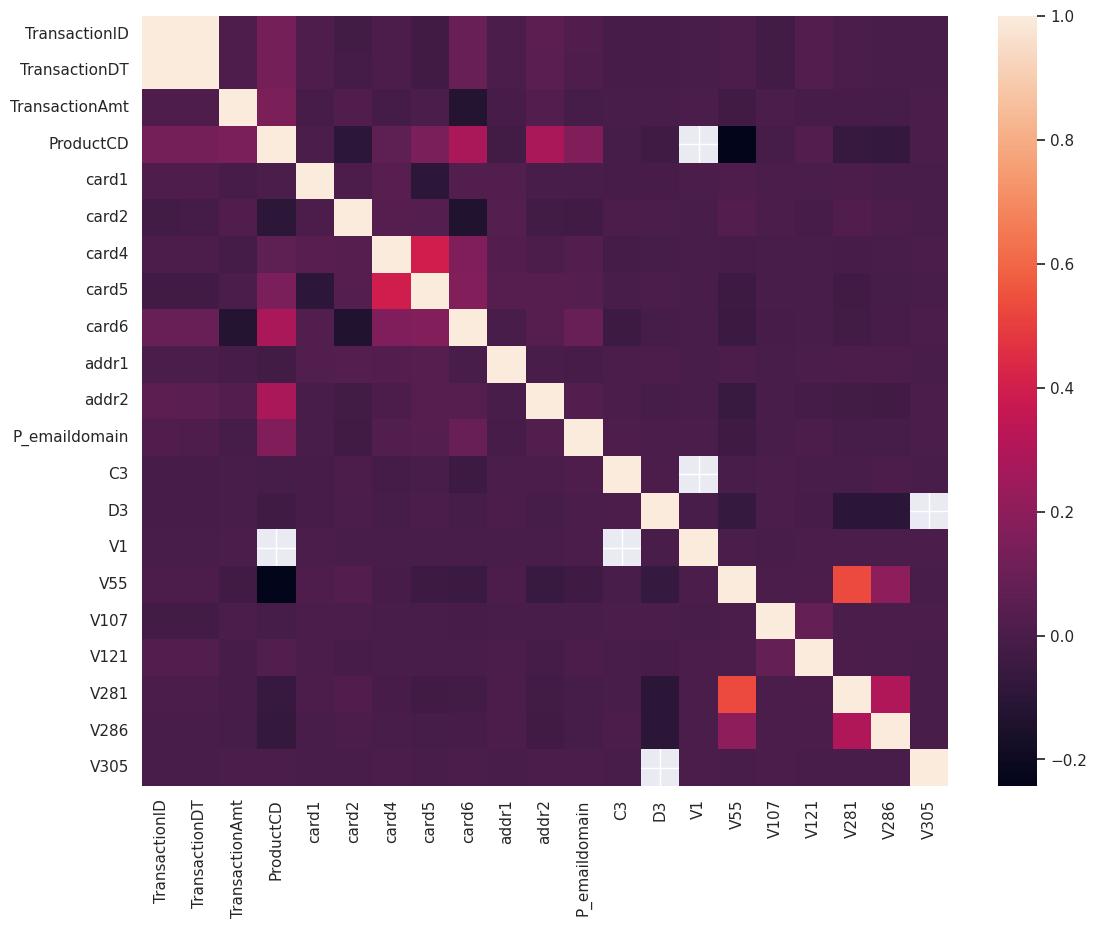

In [60]:
plt.figure(figsize=(13,10))
sns.heatmap(X_train.corr(), 
           xticklabels=X_train.columns, 
           yticklabels=X_train.columns)

Видим, что в датасете остались только слабо кореллированные признаки

### Посмотрим, есть ли в данных выбросы

Сперва отделим категориальные признаки от числовых

In [61]:
cat_feats = ['ProductCD', 'card1', 'card2', 'card4', 
             'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
num_feats = [x for x in X_train.columns if x not in cat_feats]
print(f'cat_feats:\n {cat_feats}\n')
print(f'num_feats:\n {num_feats}')

cat_feats:
 ['ProductCD', 'card1', 'card2', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']

num_feats:
 ['TransactionID', 'TransactionDT', 'TransactionAmt', 'C3', 'D3', 'V1', 'V55', 'V107', 'V121', 'V281', 'V286', 'V305']


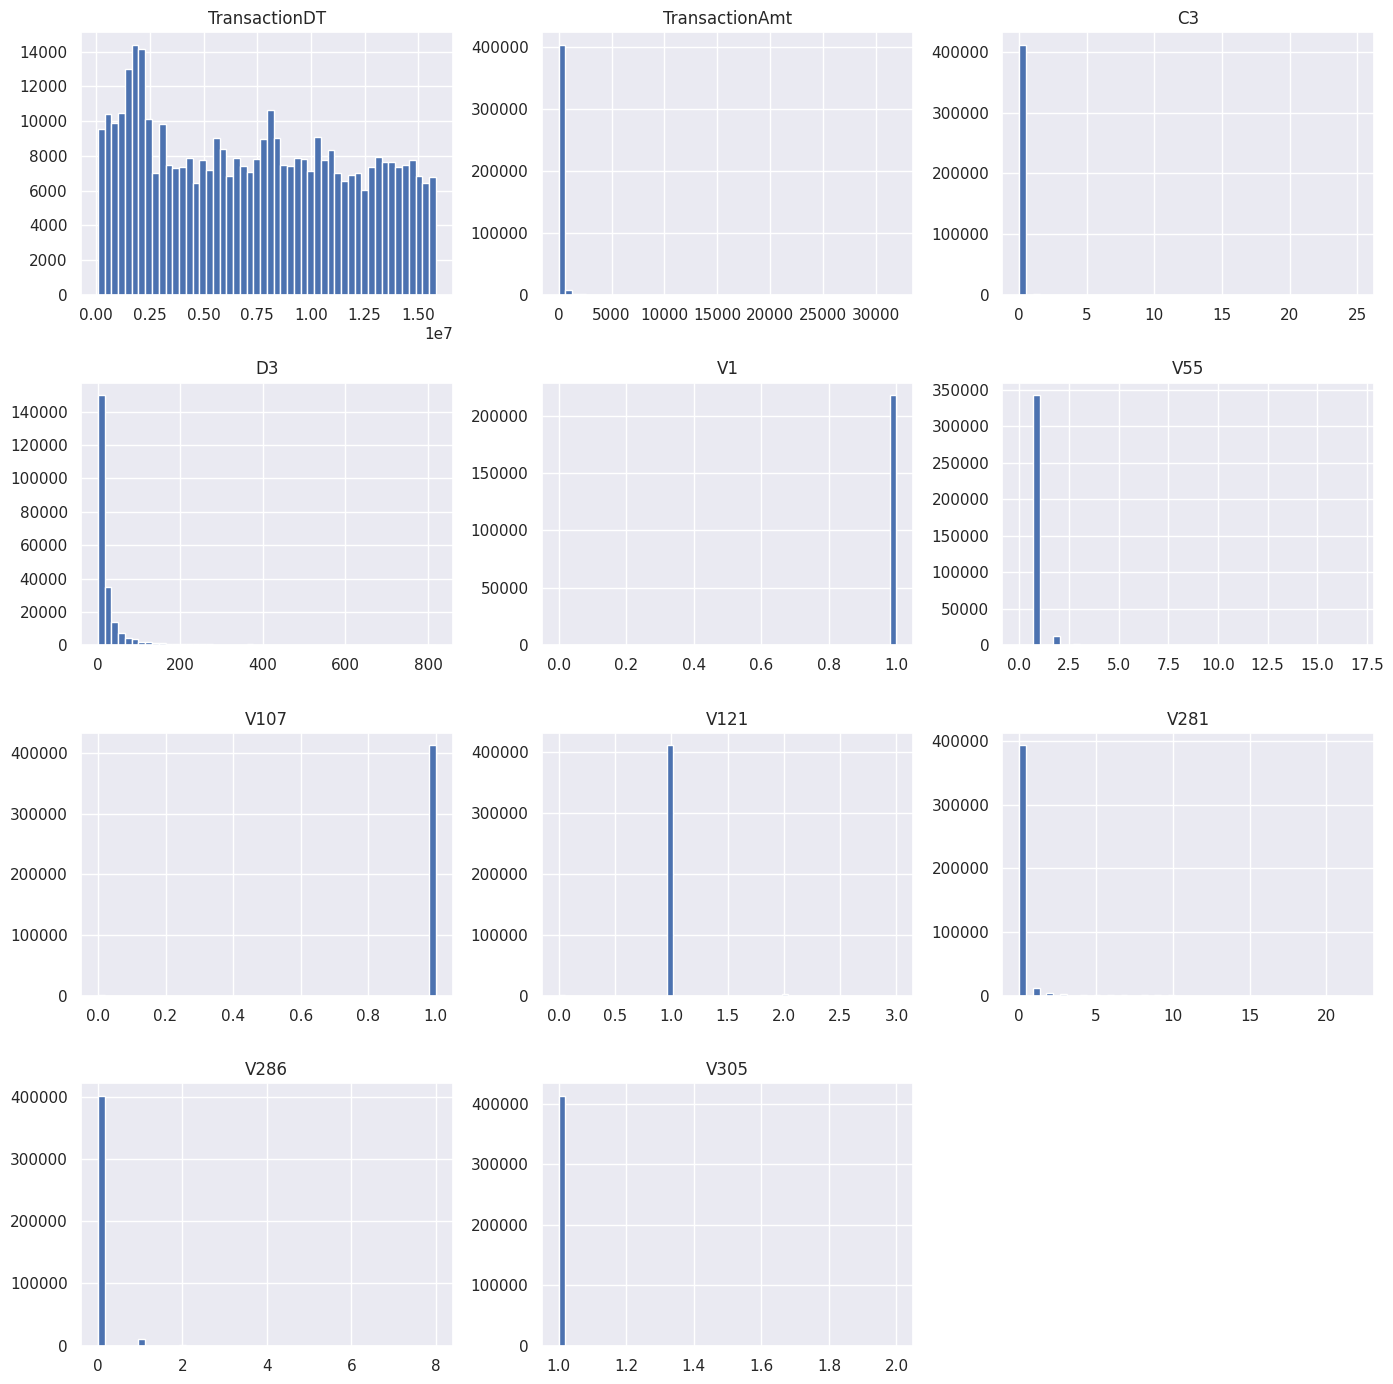

In [62]:
sns.set()
X_train[num_feats[1:]].hist(bins=50, figsize=(14,14))
plt.tight_layout()

Видим, что некоторые данные имеют выбросы. Посмотрим на графики ```boxplot```, чтобы явно убедиться в этом

In [63]:
def plt_boxplot(df, feature):
    sns.set()
    plt.figure(figsize=(10,3))
    sns.boxplot(x=df[feature])
    plt.title('Диаграмма размаха {}'.format(feature))
    plt.xlabel(feature)
    plt.show()

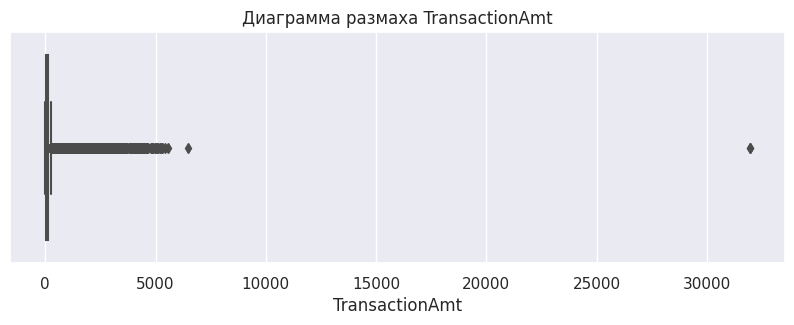

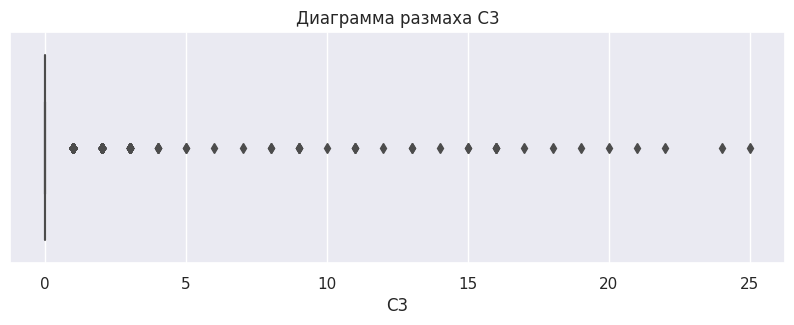

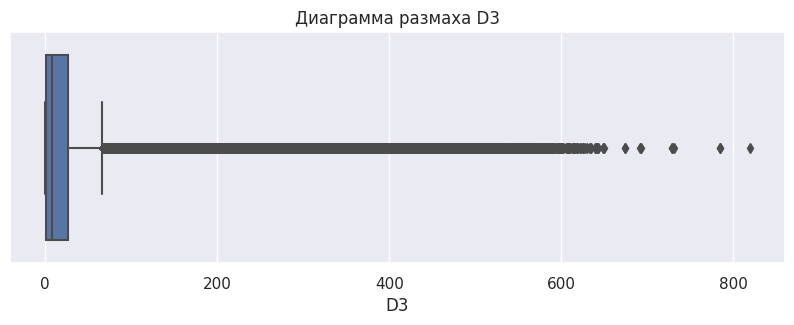

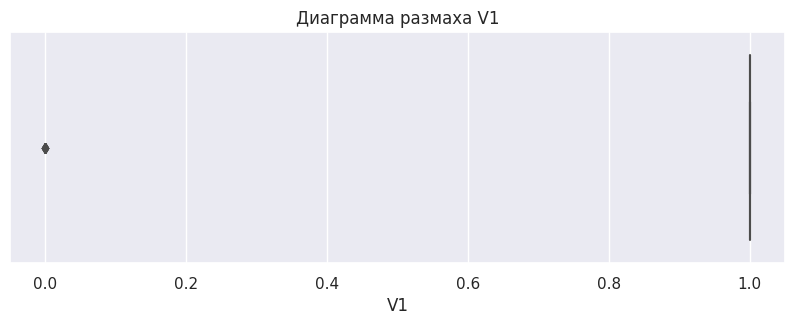

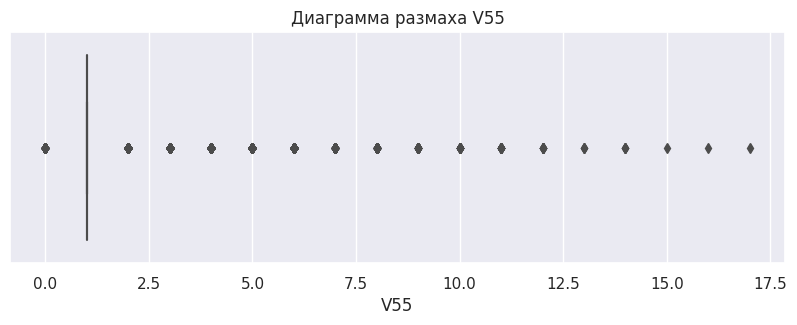

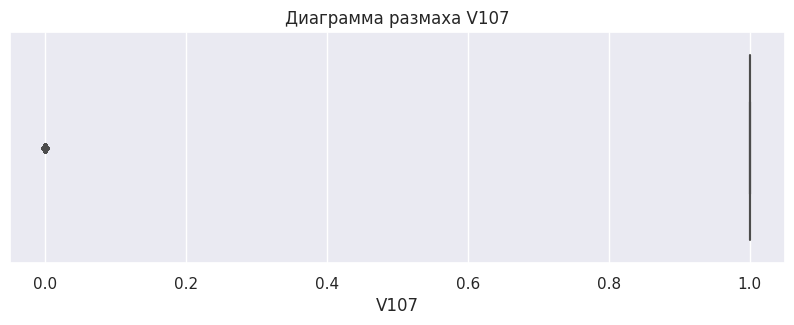

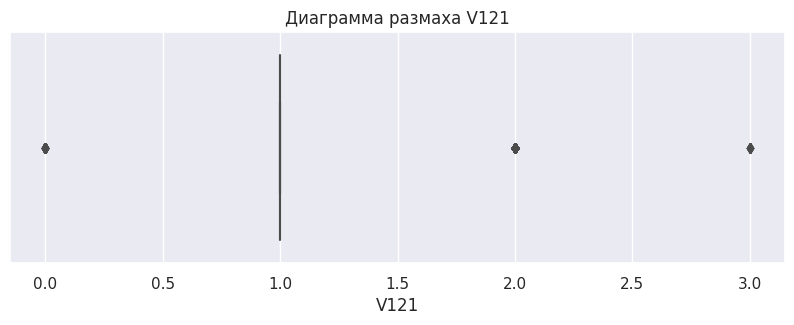

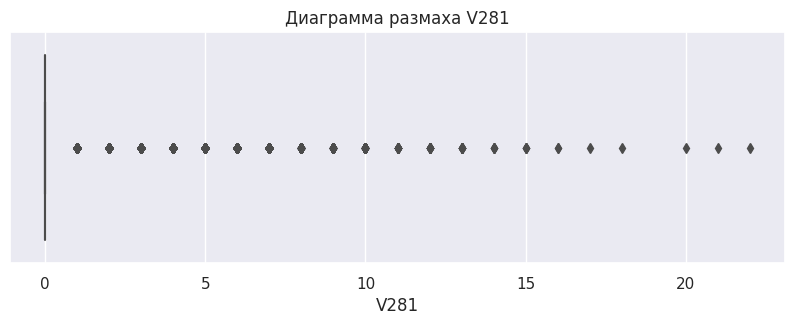

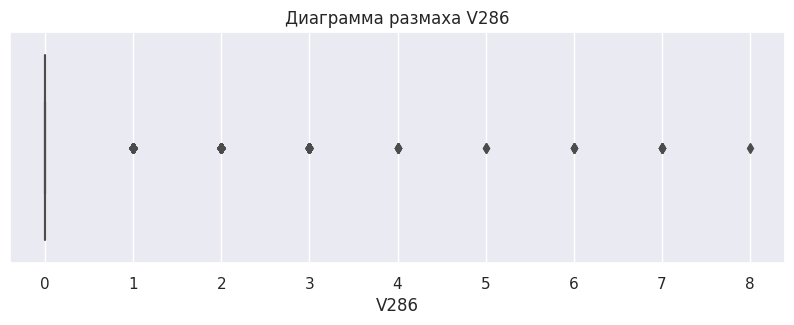

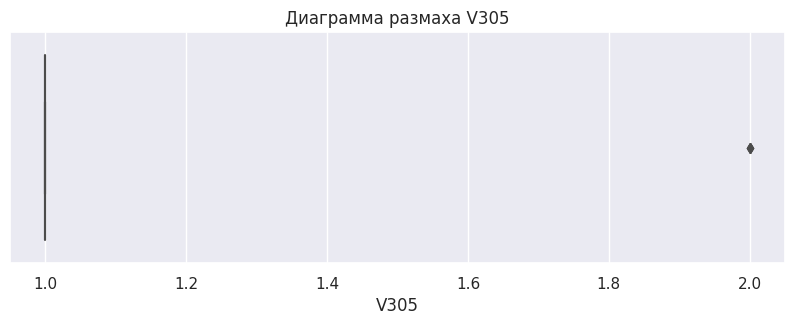

In [64]:
for feat in num_feats[2:]:
    plt_boxplot(X_train, feat)

Да, многие данные действительно имеют выбросы

### Посмотрим ещё раз на пропуски

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 581658 to 57073
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   413378 non-null  uint32 
 1   TransactionDT   413378 non-null  uint32 
 2   TransactionAmt  413378 non-null  float32
 3   ProductCD       413378 non-null  int64  
 4   card1           413378 non-null  uint16 
 5   card2           407149 non-null  float32
 6   card4           413378 non-null  int64  
 7   card5           410439 non-null  float32
 8   card6           413378 non-null  int64  
 9   addr1           367463 non-null  float32
 10  addr2           367463 non-null  float32
 11  P_emaildomain   413378 non-null  int64  
 12  C3              413378 non-null  float32
 13  D3              229206 non-null  float32
 14  V1              217866 non-null  float32
 15  V55             359386 non-null  float32
 16  V107            413155 non-null  float32
 17  V121       

In [66]:
X_train.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               6229
card4                  0
card5               2939
card6                  0
addr1              45915
addr2              45915
P_emaildomain          0
C3                     0
D3                184172
V1                195512
V55                53992
V107                 223
V121                 223
V281                 889
V286                   8
V305                   8
dtype: int64

Сперва заполним пропуски числовых признаков средним по колонке

Сделаем копии датасетов, чтобы ничего не поменять в исходниках

In [67]:
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
test_df_copy = test_df.copy()

In [68]:
num_feats

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [69]:
X_train_copy[num_feats] = X_train_copy[num_feats].fillna(
    X_train_copy[num_feats].mean())

In [70]:
X_valid_copy[num_feats] = X_valid_copy[num_feats].fillna(
    X_valid_copy[num_feats].mean())

In [71]:
test_df_copy[num_feats] = test_df_copy[num_feats].fillna(
    test_df_copy[num_feats].mean())

Пропуски в категориальных прихнаках заполним константой ```-1```

In [72]:
X_train_copy[cat_feats] = X_train_copy[cat_feats].fillna(-1)
X_valid_copy[cat_feats] = X_valid_copy[cat_feats].fillna(-1)
test_df_copy[cat_feats] = test_df_copy[cat_feats].fillna(-1)

Проверки, остались ли пропуски в данных после заполнения

In [73]:
X_train_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [74]:
X_valid_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [75]:
test_df_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### Посмотрим на распределения признаков после заполнения пропусков

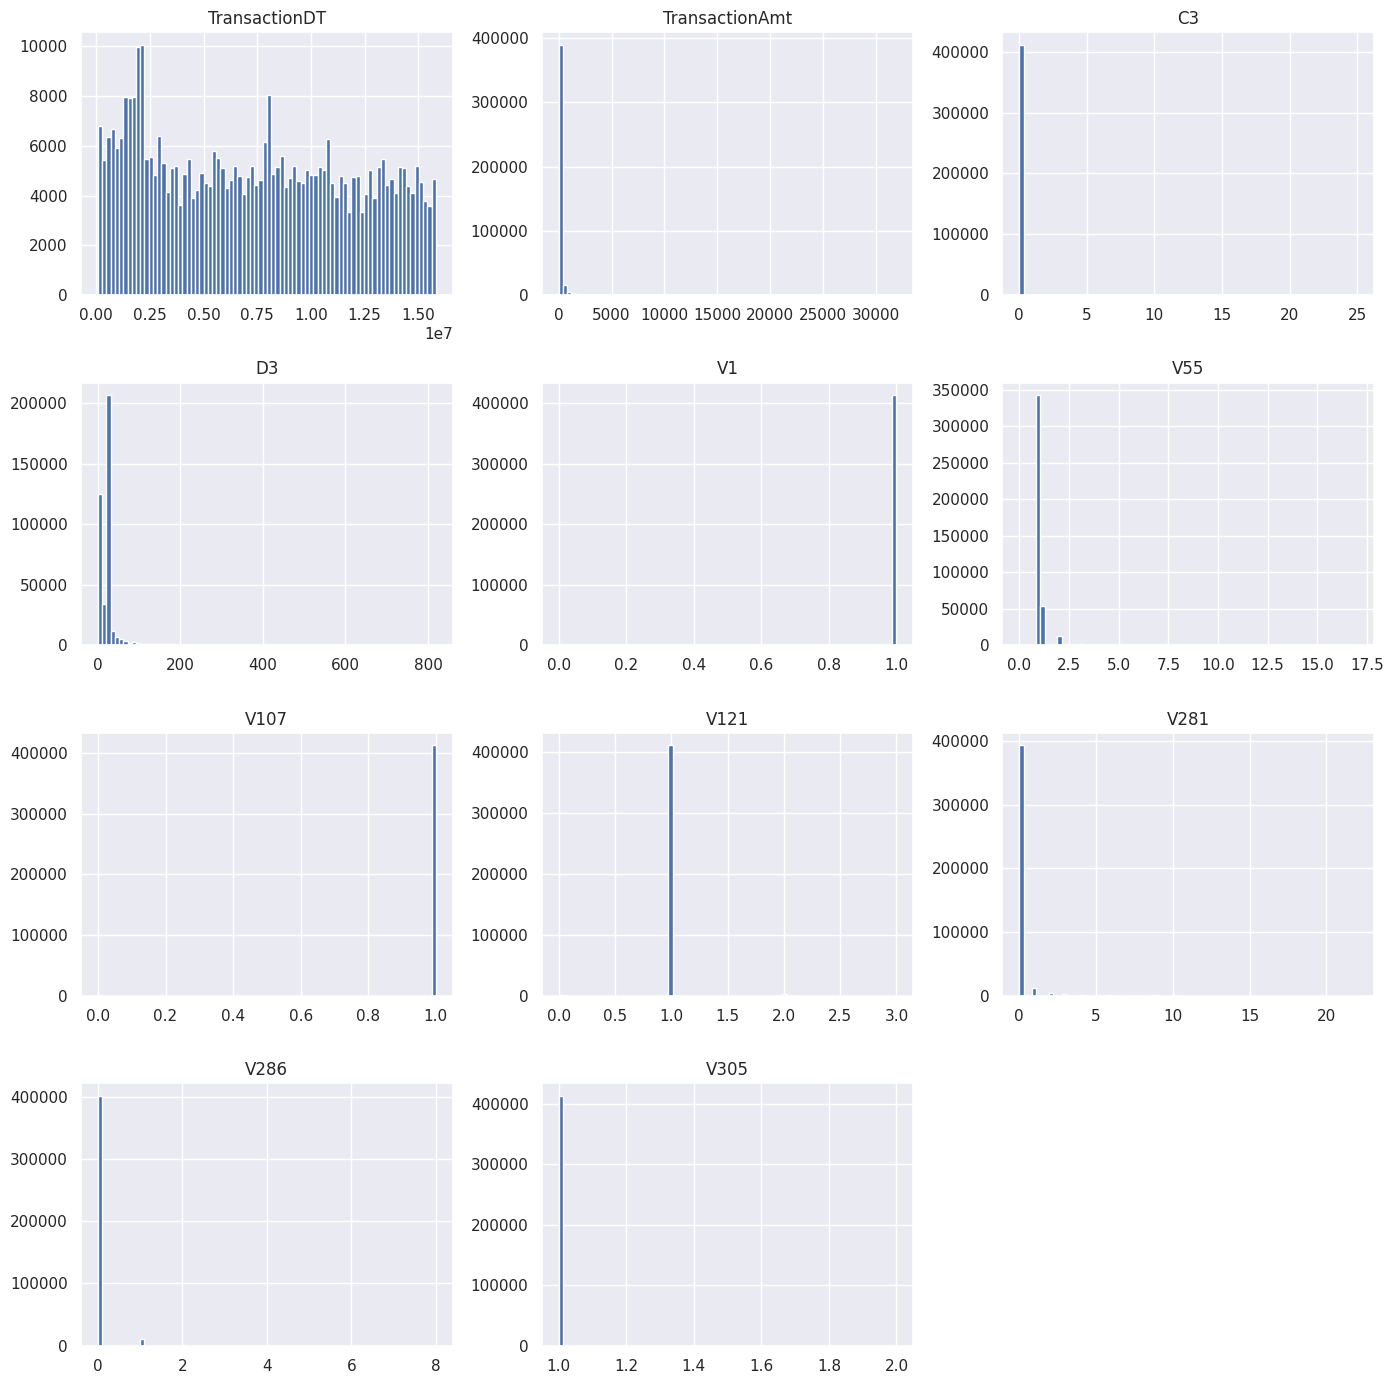

In [76]:
X_train_copy[num_feats[1:]].hist(bins=80, figsize=(14,14))
plt.tight_layout()

Видим, что распределения признаков после заполнения пропусков не изменились

#### Попробуем убрать шум в данных с помощью **метода главных компонент**

In [77]:
X_train_copy2 = X_train_copy.drop(columns=['TransactionID'])
X_train_copy2

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
581658,15533085,107.000000,4,14858,558.0,4,226.0,2,325.0,87.0,16,0.0,2.00000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
454948,11639725,108.500000,4,17188,321.0,4,226.0,2,225.0,87.0,2,0.0,312.00000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
220622,5180573,226.000000,4,16659,170.0,4,226.0,1,512.0,87.0,54,0.0,28.36557,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
409762,10354375,8.761000,0,5812,408.0,2,224.0,2,-1.0,-1.0,55,0.0,28.36557,0.999963,1.000000,1.0,1.0,0.0,0.0,1.0
283716,6928923,30.950001,4,9112,250.0,4,226.0,2,441.0,87.0,54,0.0,49.00000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42084,1023194,100.000000,3,2408,571.0,4,226.0,2,264.0,87.0,32,1.0,28.36557,0.999963,1.067318,1.0,1.0,1.0,0.0,1.0
269441,6540941,208.949997,4,16659,170.0,4,226.0,1,325.0,87.0,2,0.0,0.00000,0.999963,2.000000,1.0,1.0,2.0,0.0,1.0
218753,5106604,226.000000,4,2616,-1.0,1,102.0,1,299.0,87.0,54,0.0,28.36557,0.999963,1.000000,1.0,1.0,0.0,0.0,1.0
422738,10701858,15.000000,4,5251,555.0,4,166.0,2,123.0,87.0,16,0.0,15.00000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0


In [78]:
from sklearn import decomposition
pca = decomposition.PCA()
X_train_pca = pca.fit_transform(X_train_copy2)

Посмотрим, как выглядит вклад каждой из компонент в разброс исходных данных

In [79]:
len(pca.explained_variance_ratio_)

20

In [80]:
pca.explained_variance_ratio_

array([9.99998869e-01, 1.12597960e-06, 2.77449638e-09, 1.24348348e-09,
       8.33877616e-10, 1.00654518e-10, 8.99195038e-11, 1.84232891e-11,
       1.23817267e-11, 4.30954236e-14, 3.14154045e-14, 1.43803241e-14,
       7.51824714e-15, 3.73512247e-15, 1.49680578e-15, 1.02922621e-15,
       2.09053102e-16, 1.95823107e-17, 9.07574536e-19, 3.40339980e-19])

После этого можно принять решение, что нам нужна две компоненты, которые обеспечивает почти 100% данных о признаках

In [81]:
pca = decomposition.PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_copy2)

In [82]:
pca.explained_variance_ratio_

array([9.99998869e-01, 1.12597960e-06])

In [83]:
X_train_pca

array([[ 8.15770314e+06, -4.86813084e+03],
       [ 4.26434317e+06, -7.24514783e+03],
       [-2.19480884e+06, -6.79440554e+03],
       ...,
       [-2.26877801e+06,  7.24774727e+03],
       [ 3.32647602e+06,  4.68030797e+03],
       [-6.06310785e+06, -6.06744522e+03]])

#### Попробуем посмотреть на прогноз **логистической регрессии**

In [84]:
from sklearn.linear_model import LogisticRegression

In [85]:
model_LR = LogisticRegression()

model_LR.fit(X_train_copy, y_train)

LogisticRegression()

In [86]:
y_pred_valid_LR = model_LR.predict(X_valid_copy)

In [87]:
y_pred_proba_valid_LR = model_LR.predict_proba(X_valid_copy)

In [88]:
y_pred_proba_valid_LR

array([[0.96594581, 0.03405419],
       [0.96248535, 0.03751465],
       [0.96496972, 0.03503028],
       ...,
       [0.96500058, 0.03499942],
       [0.9676193 , 0.0323807 ],
       [0.96766016, 0.03233984]])

In [89]:
y_pred_valid_LR

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [90]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


Отличный результат, но это на валидационной выборке, и плюс распределение ответов в нашей выборке не сбалансировано

#### Посмотрим на **матрицу ошибок**

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

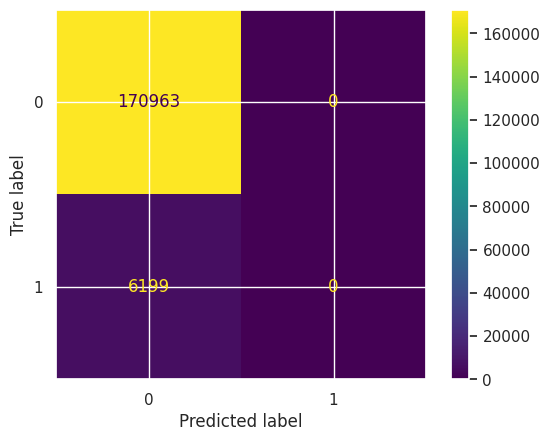

In [92]:
cm = confusion_matrix(y_valid, y_pred_valid_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Видим, что среди верных срабатываний не предсказано ни одного верного ответа

Посмотрим отчёт по метрикам классификации

In [93]:
print(classification_report(y_valid, y_pred_valid_LR))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Это потому что в данных большой дисбаланс классов

Так как размеры датасетов достаточно большие, уберём часть данных класса с большей долей (валидные) из нашей выборки

In [94]:
X_train_copy

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
581658,3568658,15533085,107.000000,4,14858,558.0,4,226.0,2,325.0,...,16,0.0,2.00000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
454948,3441948,11639725,108.500000,4,17188,321.0,4,226.0,2,225.0,...,2,0.0,312.00000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
220622,3207622,5180573,226.000000,4,16659,170.0,4,226.0,1,512.0,...,54,0.0,28.36557,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
409762,3396762,10354375,8.761000,0,5812,408.0,2,224.0,2,-1.0,...,55,0.0,28.36557,0.999963,1.000000,1.0,1.0,0.0,0.0,1.0
283716,3270716,6928923,30.950001,4,9112,250.0,4,226.0,2,441.0,...,54,0.0,49.00000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42084,3029084,1023194,100.000000,3,2408,571.0,4,226.0,2,264.0,...,32,1.0,28.36557,0.999963,1.067318,1.0,1.0,1.0,0.0,1.0
269441,3256441,6540941,208.949997,4,16659,170.0,4,226.0,1,325.0,...,2,0.0,0.00000,0.999963,2.000000,1.0,1.0,2.0,0.0,1.0
218753,3205753,5106604,226.000000,4,2616,-1.0,1,102.0,1,299.0,...,54,0.0,28.36557,0.999963,1.000000,1.0,1.0,0.0,0.0,1.0
422738,3409738,10701858,15.000000,4,5251,555.0,4,166.0,2,123.0,...,16,0.0,15.00000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0


Мы помним, что распределение целевых меток в наших данных:
- валидные транзакции - ```96,5``` %
- мошеннические транзакции - ```3,5``` %

Попробуем убрать число копий мошеннических транзакций так, чтобы соотношение классов стало равным ```70```% (валидные) к ```30``` % (мошеннические)

Посчитаем сколько записей транзакций от **общего размера обучающей выборки** составляют ```70``` %:

In [95]:
num_y_train_70_prct = len(y_train) * 0.7
int(num_y_train_70_prct)

289364

Посмотрим сколько записей **валидных транзакций** надо удалить из обучающего датасета, чтобы соотношение долей ответов стало 70 к 30:

- num_trxs       - 100 %
- num_valid_trxs - 70 %
- num_fraud_trxs - 30%

In [96]:
not_fraud_trxs_count = len(y_train[y_train==0])
fraud_trxs_count = len(y_train[y_train==1])
# посмотрим какое общее число транзакций должно быть, 
# чтобы мы смогли достичь нужного соотношения
balanced_trxs_count = int(fraud_trxs_count * 100 / 30)
print('not_fraud_trxs_count: ', not_fraud_trxs_count)
print('fraud_trxs_count: ', fraud_trxs_count)
print('balanced_trxs_count: ', balanced_trxs_count)

not_fraud_trxs_count:  398914
fraud_trxs_count:  14464
balanced_trxs_count:  48213


Видим, что **сбалансированое кол-во транзакций было бы - 48213**, но мы не можем сократить число транзакций до такого кол-ва, т.к. данных останется слишком мало, что плохо скажется на прогнозах по тестовым данным

Поэтому необходимо **добавить** необходимое число копий **мошеннических транзакций** в датасеты

In [97]:
trxs_count = len(y_train)
opt_fraud_trxs_count = int(trxs_count * 30 / 100)
print('optimal fraud trxs count: ', opt_fraud_trxs_count)

optimal fraud trxs count:  124013


Посчитаем насколько копий нужно увеличить кол-во мошеннических записей

In [98]:
diff_fraud_trxs_count = opt_fraud_trxs_count - fraud_trxs_count
diff_fraud_trxs_count

109549

Нужно добавить **109549** записей класса 1

In [99]:
int(opt_fraud_trxs_count / fraud_trxs_count)

8

#### т.е. увеличим число мошеннических транзакций примерно в 8 раз

In [100]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(7)])
y_train_fraud_increased

276301    1
222807    1
22728     1
67839     1
3907      1
         ..
391238    1
45118     1
131149    1
400078    1
245998    1
Name: isFraud, Length: 101248, dtype: uint8

In [101]:
y_train_increased = pd.concat([y_train, y_train_fraud_increased])
y_train_increased

581658    0
454948    0
220622    0
409762    0
283716    0
         ..
391238    1
45118     1
131149    1
400078    1
245998    1
Name: isFraud, Length: 514626, dtype: uint8

Посмотрим теперь на соотношение ответов

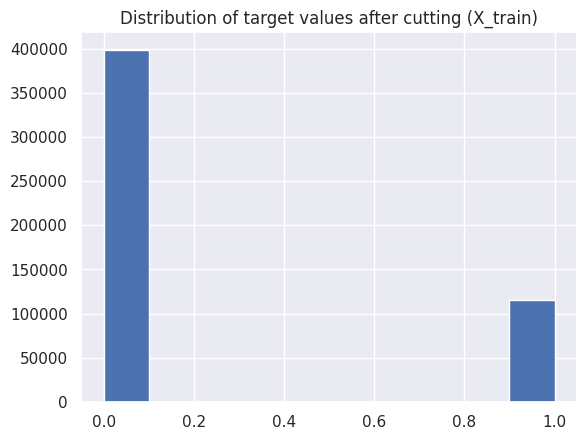

In [102]:
plt.hist(y_train_increased)
plt.title('Distribution of target values after cutting (X_train)')
plt.show()

Видим, как поменялось соотношение ответов

Увеличим кол-во соответствующих данных в датасете ```X_train```

In [103]:
before_inc = y_train[y_train==1].index
before_inc

Index([276301, 222807,  22728,  67839,   3907, 227157, 474834, 333668, 401091,
       209404,
       ...
       205144, 326430, 476412, 311313, 383190, 391238,  45118, 131149, 400078,
       245998],
      dtype='int64', length=14464)

In [104]:
y_train_indexes = list(y_train_increased[y_train_increased==1].index[len(before_inc):])
len(y_train_indexes)

101248

In [105]:
X_train_increased = pd.concat([X_train, X_train.loc[y_train_indexes]])
X_train_increased

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
581658,3568658,15533085,107.000000,4,14858,558.0,4,226.0,2,325.0,...,16,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
454948,3441948,11639725,108.500000,4,17188,321.0,4,226.0,2,225.0,...,2,0.0,312.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
220622,3207622,5180573,226.000000,4,16659,170.0,4,226.0,1,512.0,...,54,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
409762,3396762,10354375,8.761000,0,5812,408.0,2,224.0,2,NaN,...,55,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
283716,3270716,6928923,30.950001,4,9112,250.0,4,226.0,2,441.0,...,54,0.0,49.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391238,3378238,9825512,67.067001,0,9633,130.0,4,138.0,2,NaN,...,19,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
45118,3032118,1093268,124.762001,0,2801,296.0,4,137.0,1,511.0,...,19,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0
131149,3118149,2594364,24.836000,0,9917,142.0,4,138.0,2,NaN,...,19,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
400078,3387078,10092957,994.000000,4,13526,529.0,4,162.0,1,226.0,...,16,0.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [106]:
y_train_increased.shape

(514626,)

In [107]:
X_train_increased.shape

(514626, 21)

In [108]:
X_train_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8210
card4                  0
card5               3926
card6                  0
addr1              83771
addr2              83771
P_emaildomain          0
C3                     0
D3                238226
V1                267220
V55                76357
V107                 314
V121                 314
V281                1141
V286                  22
V305                  22
dtype: int64

Снова заполним пропуски в данных:
- числовые признаки средними значениями по столбцам
- категориальные - ```-1```

In [109]:
X_train_increased[num_feats] = X_train_increased[num_feats].fillna(
    X_train_increased[num_feats].mean())

In [110]:
X_train_increased[cat_feats] = X_train_increased[cat_feats].fillna(-1)

In [111]:
X_train_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

### Проделаем вышеперечисленные действия с увеличением доли **мошеннических записей** для валидационного датасета

In [112]:
y_valid_fraud_increased = pd.concat([y_valid[y_valid==1] for i in range(7)])
y_valid_fraud_increased

508005    1
246662    1
154300    1
284147    1
100971    1
         ..
523923    1
57142     1
350130    1
378077    1
533188    1
Name: isFraud, Length: 43393, dtype: uint8

In [113]:
y_valid_increased = pd.concat([y_valid, y_valid_fraud_increased])
y_valid_increased

258608    0
467328    0
325467    0
252068    0
31948     0
         ..
523923    1
57142     1
350130    1
378077    1
533188    1
Name: isFraud, Length: 220555, dtype: uint8

Посмотрим на соотношение ответов валидационного датасета

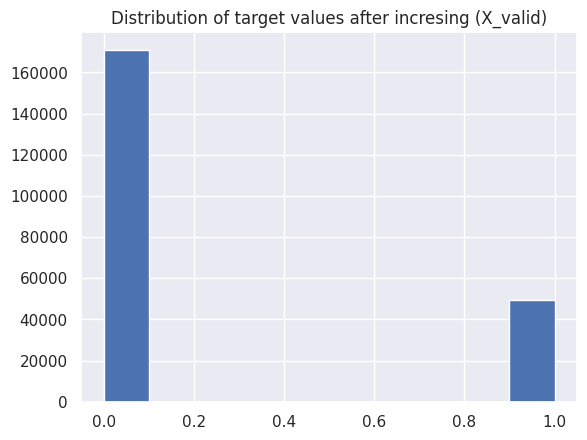

In [114]:
plt.hist(y_valid_increased)
plt.title('Distribution of target values after incresing (X_valid)')
plt.show()

In [115]:
before_inc = y_valid[y_valid==1].index
y_valid_indexes = list(y_valid_increased[y_valid_increased==1].index[len(before_inc):])
X_valid_increased = pd.concat([X_valid, X_valid.loc[y_valid_indexes]])
X_valid_increased

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
258608,3245608,6204621,34.000000,4,15077,127.0,2,102.0,1,272.0,...,54,0.0,5.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
467328,3454328,12048998,171.000000,4,17321,111.0,4,226.0,2,494.0,...,54,0.0,204.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0
325467,3312467,8026823,77.000000,4,12695,490.0,4,226.0,2,325.0,...,9,0.0,545.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
252068,3239068,6024807,87.000000,4,15813,251.0,4,226.0,2,441.0,...,32,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
31948,3018948,782287,30.000000,4,13481,199.0,2,224.0,2,325.0,...,32,0.0,1.0,NaN,1.0,1.0,1.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523923,3510923,13755584,31.969999,0,1976,545.0,4,102.0,1,NaN,...,16,0.0,1.0,NaN,4.0,1.0,1.0,0.0,0.0,1.0
57142,3044142,1314711,66.579002,0,9633,130.0,4,138.0,2,NaN,...,16,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
350130,3337130,8631619,26.705999,0,16746,500.0,2,102.0,1,NaN,...,32,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
378077,3365077,9469788,470.000000,4,5222,111.0,4,195.0,1,512.0,...,29,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [116]:
y_valid_increased.shape

(220555,)

In [117]:
X_valid_increased.shape

(220555, 21)

Заполним пропуски в валидационном датасете

In [118]:
X_valid_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               3684
card4                  0
card5               1803
card6                  0
addr1              36122
addr2              36122
P_emaildomain          0
C3                     0
D3                101960
V1                113966
V55                32302
V107                 119
V121                 119
V281                 450
V286                   4
V305                   4
dtype: int64

In [119]:
X_valid_increased[num_feats] = X_valid_increased[num_feats].fillna(
    X_valid_increased[num_feats].mean())

In [120]:
X_valid_increased[cat_feats] = X_valid_increased[cat_feats].fillna(-1)

In [121]:
X_valid_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### После добавления данных в датасеты посмотрим снова на прогноз модели логистической регрессии:

In [122]:
model_LR2 = LogisticRegression()
model_LR2.fit(X_train_increased, y_train_increased)

LogisticRegression()

In [123]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_increased)
y_pred_proba_valid_LR2 = model_LR2.predict_proba(X_valid_increased)

In [124]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid_increased).sum()/len(y_valid_increased)}')

Доля верно угаданных объектов 0.7751490557910725


Видим, что качество прогнозов ухудшилось. Посмотрим на матрицу ошибок и отчёт классификации

Напишем функцию для построения матрицы ошибок:

In [125]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

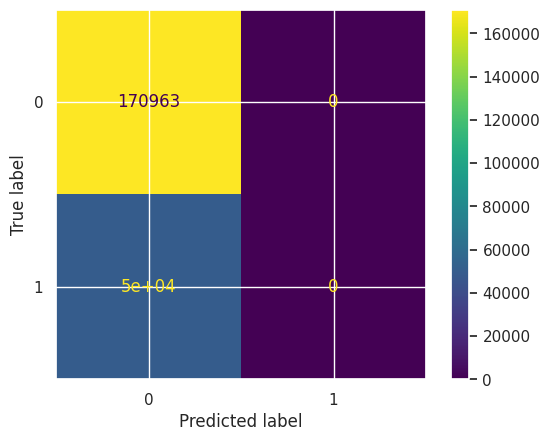

In [126]:
conf_matrix(y_valid_increased, y_pred_valid_LR2)

In [127]:
print(classification_report(y_valid_increased, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87    170963
           1       0.00      0.00      0.00     49592

    accuracy                           0.78    220555
   macro avg       0.39      0.50      0.44    220555
weighted avg       0.60      0.78      0.68    220555



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Попробуем сделать прогноз на исходной выборке ```X_valid_copy``` с дисбалансом в данных

In [128]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_copy)
y_pred_proba_valid_LR2 = model_LR2.predict_proba(X_valid_copy)

In [129]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


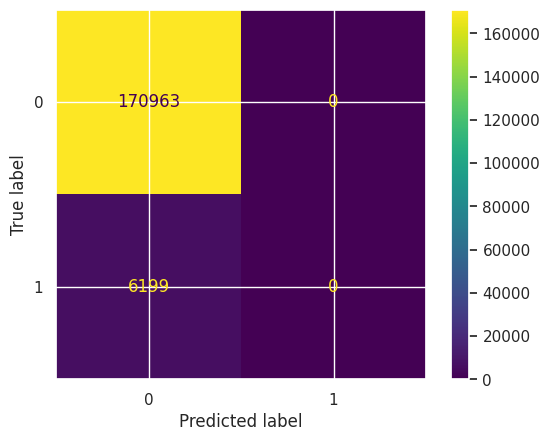

In [130]:
conf_matrix(y_valid, y_pred_valid_LR2)

In [131]:
print(classification_report(y_valid, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Видим, что среди верных срабатываний доля верно предсказанных значений мошеннических транзакций увеличилась, но число ошибок также очень большое

#### Но попробуем сбалансировать значения двух выборок 50 на 50. Уменьшим кол-во записей в датасете с классом 0

In [132]:
opt_fraud_trxs_count

124013

In [133]:
not_fraud_trxs_count

398914

In [134]:
balanced_y_train_0 = y_train[y_train==0][:opt_fraud_trxs_count]
balanced_y_train_0

581658    0
454948    0
220622    0
409762    0
283716    0
         ..
386555    0
443419    0
380871    0
418232    0
445859    0
Name: isFraud, Length: 124013, dtype: uint8

In [135]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(8)])
y_train_fraud_increased

276301    1
222807    1
22728     1
67839     1
3907      1
         ..
391238    1
45118     1
131149    1
400078    1
245998    1
Name: isFraud, Length: 115712, dtype: uint8

In [136]:
y_train_balanced = pd.concat([balanced_y_train_0, y_train_fraud_increased])
y_train_balanced

581658    0
454948    0
220622    0
409762    0
283716    0
         ..
391238    1
45118     1
131149    1
400078    1
245998    1
Name: isFraud, Length: 239725, dtype: uint8

Посмотрим теперь на соотношение ответов

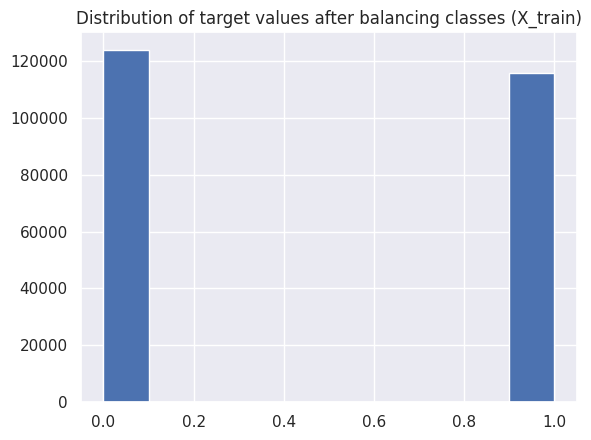

In [137]:
plt.hist(y_train_balanced)
plt.title('Distribution of target values after balancing classes (X_train)')
plt.show()

In [138]:
y_train_balanced.shape

(239725,)

In [139]:
X_train_balanced = X_train_copy.loc[y_train_balanced.index]

In [140]:
X_train_balanced.shape

(239725, 21)

In [141]:
test_df.shape

(506691, 21)

In [142]:
model_LR4 = LogisticRegression()
model_LR4.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [143]:
y_pred_valid_LR4 = model_LR4.predict(X_valid_copy)

In [144]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR4 == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.7227960849392082


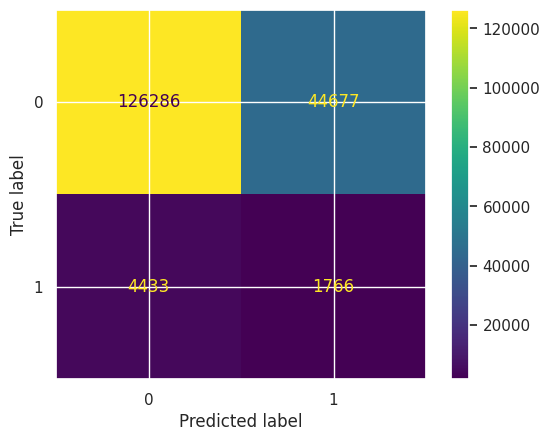

In [145]:
conf_matrix(y_valid, y_pred_valid_LR4)

In [146]:
print(classification_report(y_valid, y_pred_valid_LR4))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84    170963
           1       0.04      0.28      0.07      6199

    accuracy                           0.72    177162
   macro avg       0.50      0.51      0.45    177162
weighted avg       0.93      0.72      0.81    177162



Видим, что качество после уравнивания долей ответов обоих классов по прежнему остаётся не очень хорошим, хоть и полнота для класса 1 выросла

#### Так как линейные модели чувствительны к порядкам признаков, необходимо произвести **масштабирование признаков**

In [147]:
from sklearn.preprocessing import StandardScaler

Уберём из датасета признак ```TransactionID```

In [148]:
X_train_balanced2 = X_train_balanced.drop(columns=['TransactionID'])
X_train_balanced2

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
581658,15533085,107.000000,4,14858,558.0,4,226.0,2,325.0,87.0,16,0.0,2.00000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0
454948,11639725,108.500000,4,17188,321.0,4,226.0,2,225.0,87.0,2,0.0,312.00000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0
220622,5180573,226.000000,4,16659,170.0,4,226.0,1,512.0,87.0,54,0.0,28.36557,1.000000,1.0,1.0,1.0,0.0,0.0,1.0
409762,10354375,8.761000,0,5812,408.0,2,224.0,2,-1.0,-1.0,55,0.0,28.36557,0.999963,1.0,1.0,1.0,0.0,0.0,1.0
283716,6928923,30.950001,4,9112,250.0,4,226.0,2,441.0,87.0,54,0.0,49.00000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391238,9825512,67.067001,0,9633,130.0,4,138.0,2,-1.0,-1.0,19,0.0,28.36557,0.999963,1.0,1.0,1.0,0.0,0.0,1.0
45118,1093268,124.762001,0,2801,296.0,4,137.0,1,511.0,60.0,19,0.0,0.00000,0.999963,1.0,1.0,1.0,1.0,1.0,1.0
131149,2594364,24.836000,0,9917,142.0,4,138.0,2,-1.0,-1.0,19,0.0,0.00000,0.999963,1.0,1.0,1.0,0.0,0.0,1.0
400078,10092957,994.000000,4,13526,529.0,4,162.0,1,226.0,87.0,16,0.0,3.00000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0


In [149]:
X_valid_copy2 = X_valid_copy.drop(columns=['TransactionID'])
X_valid_copy2

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
258608,6204621,34.000000,4,15077,127.0,2,102.0,1,272.0,87.0,54,0.0,5.000000,0.999904,1.0,1.0,1.0,0.0,0.0,1.0
467328,12048998,171.000000,4,17321,111.0,4,226.0,2,494.0,87.0,54,0.0,204.000000,1.000000,2.0,1.0,1.0,0.0,0.0,1.0
325467,8026823,77.000000,4,12695,490.0,4,226.0,2,325.0,87.0,9,0.0,545.000000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0
252068,6024807,87.000000,4,15813,251.0,4,226.0,2,441.0,87.0,32,0.0,28.291613,1.000000,1.0,1.0,1.0,0.0,0.0,1.0
31948,782287,30.000000,4,13481,199.0,2,224.0,2,325.0,87.0,32,0.0,1.000000,0.999904,1.0,1.0,1.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117366,2297780,150.000000,2,13883,127.0,2,224.0,2,204.0,87.0,54,0.0,28.291613,0.999904,1.0,1.0,1.0,0.0,0.0,1.0
447736,11399969,44.143002,0,4329,238.0,4,102.0,1,284.0,60.0,19,0.0,28.291613,0.999904,1.0,1.0,1.0,0.0,0.0,1.0
327053,8042393,34.500000,4,13982,218.0,2,117.0,2,512.0,87.0,19,0.0,471.000000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0
49357,1182265,57.950001,4,9561,242.0,4,166.0,2,444.0,87.0,54,0.0,36.000000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0


In [150]:
scaler = StandardScaler()
scaler.fit(X_train_balanced2, y_train_balanced)
X_train_sc = pd.DataFrame(scaler.transform(X_train_balanced2), 
                          index=X_train_balanced2.index,
                          columns=X_train_balanced2.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid_copy2), 
                         index=X_valid_copy2.index,
                         columns=X_valid_copy2.columns)

Построим лог. регрессию на новых данных

In [151]:
model_LR_sc = LogisticRegression()
model_LR_sc.fit(X_train_sc, y_train_balanced)
y_pred_valid_LR_sc = model_LR_sc.predict(X_valid_sc)
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_sc == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.764441584538445


Видим, что доля верно угаданных ответов немного выросла

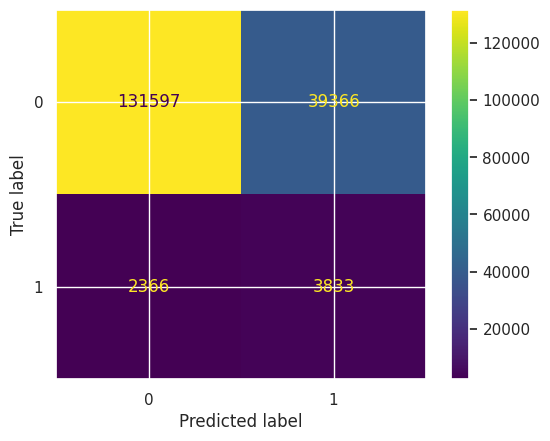

In [152]:
conf_matrix(y_valid, y_pred_valid_LR_sc)

In [153]:
print(classification_report(y_valid, y_pred_valid_LR_sc))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.62      0.16      6199

    accuracy                           0.76    177162
   macro avg       0.54      0.69      0.51    177162
weighted avg       0.95      0.76      0.84    177162



#### По матрице ошибок и отчёту классификации видно, что полнота предсказаных значений класса ```1``` **значительно выросла**

#### Теперь попробуем убрать шум в данных при помощи **метода главных компонент**

In [154]:
X_train_sc

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
581658,1.767466,-0.150676,0.765239,1.056946,1.218326,0.714262,0.677704,0.717998,0.658974,0.559376,-0.500390,-0.028847,-0.574784,0.010282,-0.242716,0.018288,-0.075725,-0.228972,-0.172093,-0.002043
454948,0.908419,-0.144181,0.765239,1.537906,-0.224670,0.714262,0.677704,0.717998,0.005831,0.559376,-1.411945,-0.028847,7.252848,0.010282,-0.242716,0.018288,-0.075725,-0.228972,-0.172093,-0.002043
220622,-0.516756,0.364562,0.765239,1.428709,-1.144047,0.714262,0.677704,-1.313493,1.880351,0.559376,1.973832,-0.028847,0.090958,0.010282,-0.242716,0.018288,-0.075725,-0.228972,-0.172093,-0.002043
409762,0.624814,-0.576024,-1.544310,-0.810337,0.305037,-1.199043,0.635161,0.717998,-1.470273,-1.807942,2.038943,-0.028847,0.090958,-0.002430,-0.242716,0.018288,-0.075725,-0.228972,-0.172093,-0.002043
283716,-0.130993,-0.479951,0.765239,-0.129148,-0.656960,0.714262,0.677704,0.717998,1.416620,0.559376,1.973832,-0.028847,0.611986,0.010282,-0.242716,0.018288,-0.075725,-0.228972,-0.172093,-0.002043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391238,0.508123,-0.323575,-1.544310,-0.021603,-1.387590,0.714262,-1.194176,0.717998,-1.470273,-1.807942,-0.305057,-0.028847,0.090958,-0.002430,-0.242716,0.018288,-0.075725,-0.228972,-0.172093,-0.002043
45118,-1.418597,-0.073771,-1.544310,-1.431870,-0.376885,0.714262,-1.215447,-1.313493,1.873820,-0.166960,-0.305057,-0.028847,-0.625285,-0.002430,-0.242716,0.018288,-0.075725,1.051383,4.903256,-0.002043
131149,-1.087388,-0.506423,-1.544310,0.037020,-1.314527,0.714262,-1.194176,0.717998,-1.470273,-1.807942,-0.305057,-0.028847,-0.625285,-0.002430,-0.242716,0.018288,-0.075725,-0.228972,-0.172093,-0.002043
400078,0.567133,3.689792,0.765239,0.781993,1.041757,0.714262,-0.683663,-1.313493,0.012362,0.559376,-0.500390,-0.028847,-0.549534,0.010282,-0.242716,0.018288,-0.075725,-0.228972,-0.172093,-0.002043


In [155]:
from sklearn import decomposition

In [156]:
pca = decomposition.PCA()
pca.fit(X_train_sc)
X_train_norm = pca.transform(X_train_sc)
X_valid_norm = pca.transform(X_valid_sc)

Посмотрим, как выглядит вклад каждой из компонент в разброс исходных данных

In [157]:
pca.explained_variance_ratio_

array([0.14625419, 0.08158423, 0.0679002 , 0.05872322, 0.05307952,
       0.0514426 , 0.05045776, 0.05002029, 0.05001012, 0.0497646 ,
       0.04837407, 0.04731904, 0.04660942, 0.04439493, 0.0435316 ,
       0.0350669 , 0.03136566, 0.02431737, 0.01472887, 0.00505541])

Видим, что большая часть компонент вносит примерно равный вклад в разброс исходных данных, поэтому будем обучать модель с использованием всех компонент

In [158]:
classifiers = [('DT', DecisionTreeClassifier()),
               ('RF', RandomForestClassifier()),
               ('Adaboost', AdaBoostClassifier()),
               ('GBM', GradientBoostingClassifier()),
               ('XGBBoost', XGBClassifier()),
               ('LightGBM', LGBMClassifier()),]